In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 18.4 MB/s eta 0:00:00


In [ ]:
# importing the libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertConfig, TFDistilBertModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
# Importing the train and testing dataset

data = pd.read_csv('/content/drive/MyDrive/Data Science/Project/Dataset/NLP UniAcco/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Data Science/Project/Dataset/NLP UniAcco/test.csv')

In [ ]:
#  1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech

data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
test_data.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
# Merging the both columns 'Title' and 'Description' together in both test and training data....

data['Text'] = data[['Title', 'Description']].agg(' '.join, axis = 1)

test_data['Text'] = test_data[['Title', 'Description']].agg(' '.join, axis = 1)

In [ ]:
# Dropping both columns 'Title' and 'Description'

data.drop(['Title', 'Description'], axis = 1, inplace = True)

test_data.drop(['Title', 'Description'], axis = 1, inplace = True)

In [ ]:
data.head()

,Class Index,Text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [ ]:
test_data.head()

,Class Index,Text
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


In [ ]:
# Shape of datasets

print(f"Train data shape : {data.shape}")
print(f"Test data shape : {test_data.shape}")

Train data shape : (120000, 2)
Test data shape : (7600, 2)


In [ ]:
categ = ['Business', 'Tech', 'Sports', 'World']

In [ ]:
data['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

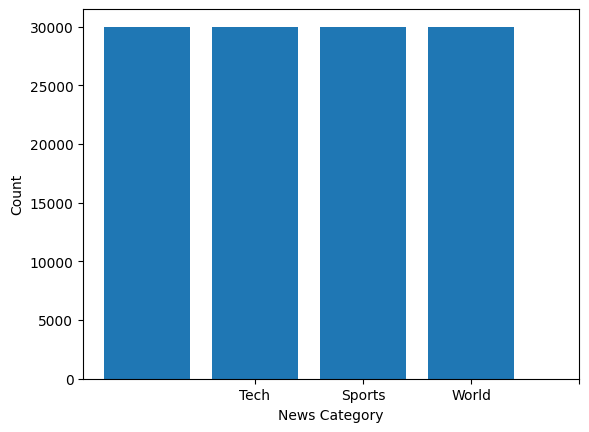

In [ ]:
# plotting class index count value
import matplotlib.pyplot as plt

plt.bar(categ, data['Class Index'].value_counts())
plt.xticks(np.arange(1,5))
plt.ylabel('Count')
plt.xlabel('News Category')
plt.show()

In [ ]:
data['Text'][0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [ ]:
# Checking Null Values

data.isnull().sum()

Class Index    0
Text           0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Text         120000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


# Data Preprocessing

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

# creating object for Porter Stemmer
ps = PorterStemmer()

# function to perform Preprocessing on text data
def clean_text(df, stop_words):
  corp = []
  for i in range(len(df)):
    # removing punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['Text'][i])

    # changing all words to lowercase and splitting them
    text = text.lower()
    text = text.split()

    # Stemming the words and removing the words present in stop_words set
    text = [ps.stem(word) for word in text if word not in stop_words]

    # joining the words back to form text lines..
    text = ' '.join(text)

    # storing all the text inside the 'corp' list...
    corp.append(text)

  return corp

In [ ]:
# calling the function to remove stopwords and punctuations
data['Text'] = clean_text(data, stop_words)

In [ ]:
test_data['Text'] = clean_text(test_data, stop_words)

In [ ]:
X_train = data['Text']
y_train = data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

x_test = test_data['Text']
y_test = test_data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

maxlen = X_train.map(lambda x: len(x.split())).max()

# Tokenizer

In [ ]:
vocab_size = 20000
embed_size = 32
bert = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(bert,
                                          add_special_tokens = True,
                                          max_length = maxlen,
                                          pad_to_max_length = True)

def tokenize(sentences, tokenizer):
    input_ids, input_masks = [],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(sentence,
                                       add_special_tokens = True,
                                       max_length = maxlen,
                                       pad_to_max_length = True,
                                       return_attention_mask = True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])

    return np.asarray(input_ids, dtype = 'int32'), np.asarray(input_masks, dtype = 'int32')

In [ ]:
# Tokenize desc and title train data
X_train = tokenize(X_train, tokenizer)
x_test = tokenize(x_test, tokenizer)

  0%|          | 0/120000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 7600/7600 [00:06<00:00, 1263.79it/s]


# Bert Model

In [ ]:
config = DistilBertConfig(dropout = 0.2, attention_dropout = 0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(bert, config = config)

input_ids_in = tf.keras.layers.Input(shape = (maxlen,), name = 'input_token', dtype = 'int32')
input_masks_in = tf.keras.layers.Input(shape = (maxlen,), name = 'masked_token', dtype = 'int32')

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(4, activation='sigmoid')(X)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 131)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 131)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 131, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
es = EarlyStopping(
         monitor = 'val_accuracy',
         min_delta = 1e-4,
         patience = 3,
         verbose = 1
     )
cp = ModelCheckpoint(
        filepath = 'best_model.h$',
        monitor = 'val_accuracy',
        mode = 'max',
        save_best_only = True,
        save_weights_only = True,
        verbose = 1
    )

# creating a list of callback modules
callbacks = [cp, es]

In [ ]:
# compiling the model and then training the model

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 1024, validation_data = (x_test, y_test), epochs = 5, callbacks = callbacks)

Epoch 1/5
118/118 [==============================] - ETA: 0s - loss: 0.4802 - accuracy: 0.8336
Epoch 1: val_accuracy improved from -inf to 0.88184, saving model to best_model.h$
118/118 [==============================] - 617s 5s/step - loss: 0.4802 - accuracy: 0.8336 - val_loss: 0.3423 - val_accuracy: 0.8818
Epoch 2/5
118/118 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8770
Epoch 2: val_accuracy improved from 0.88184 to 0.89053, saving model to best_model.h$
118/118 [==============================] - 595s 5s/step - loss: 0.3550 - accuracy: 0.8770 - val_loss: 0.3188 - val_accuracy: 0.8905
Epoch 3/5
118/118 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8872
Epoch 3: val_accuracy improved from 0.89053 to 0.89908, saving model to best_model.h$
118/118 [==============================] - 603s 5s/step - loss: 0.3266 - accuracy: 0.8872 - val_loss: 0.2920 - val_accuracy: 0.8991
Epoch 4/5
118/118 [==============================] - ETA: 0s - l

# Validation text

In [ ]:
# loading back the best model weights

model.load_weights('best_model.h$')

In [ ]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

test = ['new evidence of virus risks from wildlife trade',
        'coronavirus: Bank pumps £100bn into uk economy to aid recovery',
        'trumps bid to end obama-era immigration policy ruled unlawful',
        'david luiz’s future with arsenal to be decided this week',
        'I.R.S. Unveils $80 Billion Plan to Overhaul Tax Collection']

df_test = pd.DataFrame(test, columns = ['Text'])


In [ ]:
# calling clean_text function to remove stopwords and punctuations
test_seq = clean_text(df_test, stop_words)

In [ ]:
# transforming the input for the model
test_seq = tokenize(test_seq, tokenizer)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 5/5 [00:00<00:00, 911.96it/s]


In [ ]:
# making predictions

test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

1/1 [==============================] - 0s 137ms/step


In [ ]:
# printing results
for news, label in zip(test, test_preds):
  print(f'{news} : {label}')

new evidence of virus risks from wildlife trade : Science-Technology News
coronavirus: Bank pumps £100bn into uk economy to aid recovery : Business News
trumps bid to end obama-era immigration policy ruled unlawful : World News
david luiz’s future with arsenal to be decided this week : World News
I.R.S. Unveils $80 Billion Plan to Overhaul Tax Collection : Business News


# Confusion matrix

238/238 [==============================] - 36s 153ms/step


<Figure size 640x480 with 0 Axes>

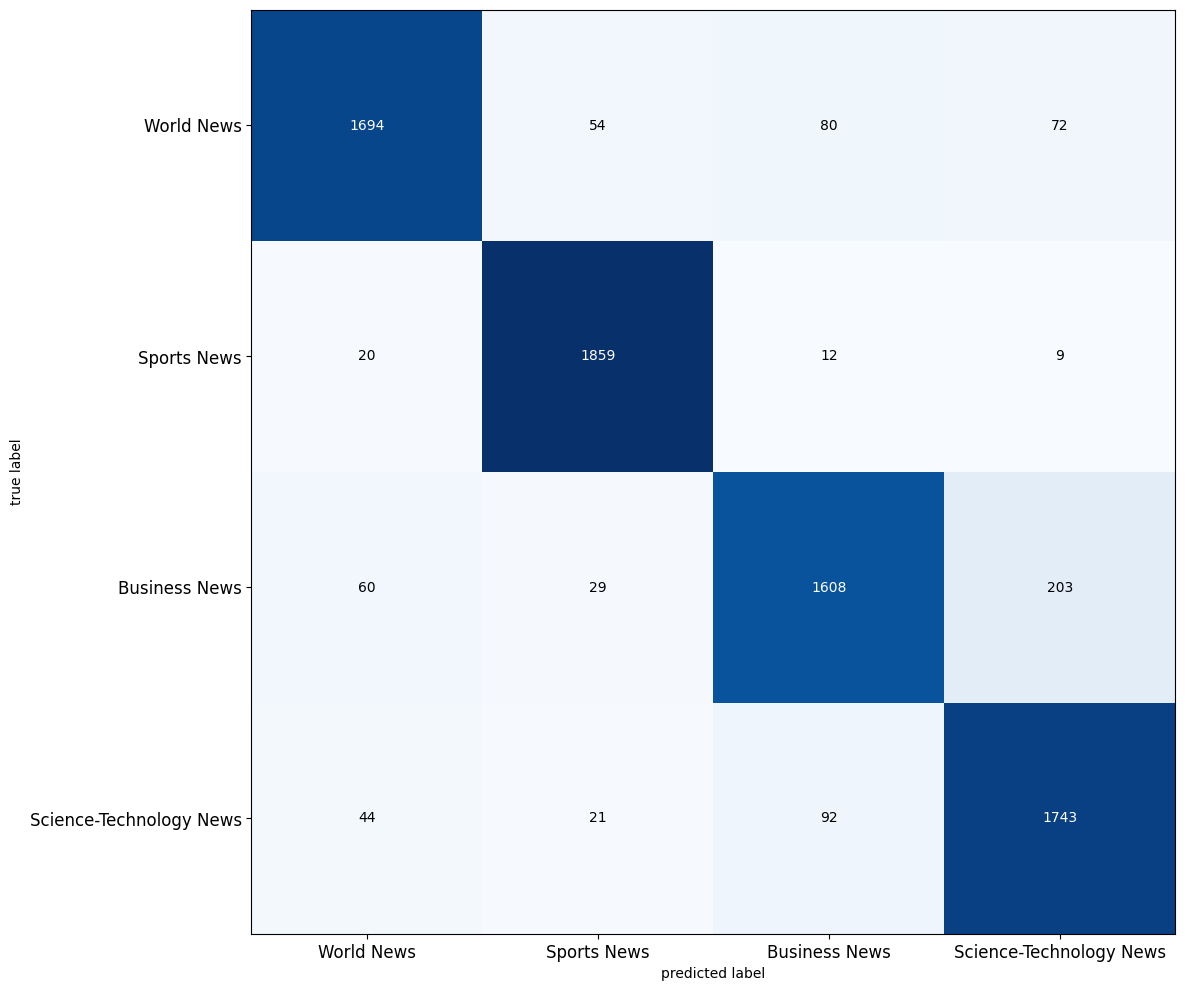

In [ ]:
# a list of prediction labels for the validation data
preds = [np.argmax(i) for i in model.predict(x_test)]

# creatin confusion matrix
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize = (16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize = 12)
plt.yticks(range(4), labels, fontsize = 12)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
print(f"Recall of the model is : {recall_score(y_test, preds, average='micro')}")
print(f"Precision of the model is : {precision_score(y_test, preds, average='micro')}")
print(f"Acuuracy of the model is : {accuracy_score(y_test, preds)}")
print(f"F1 Score of the model is : {f1_score(y_test, preds, average='micro')}")

Recall of the model is : 0.9084210526315789
Precision of the model is : 0.9084210526315789
Acuuracy of the model is : 0.9084210526315789
F1 Score of the model is : 0.9084210526315789
